# MODELO RANDOM FOREST

## Rubén Cobarro Martínez y Javier Serrat

# Importación de librerias

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import category_encoders as ce
from category_encoders.target_encoder import TargetEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
import plotly.express as px
import category_encoders as ce
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

# Lectura del CSV.

In [3]:
df_car = pd.read_csv('df_car.csv')

C:\Users\ASus\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (15,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Comprobamos primeramente la existencia de NaN en el data set antes de realizar el encoding de las columnas categoricas

In [4]:
def access_NA(df_car):
    
    null_sum = df_car.isnull().sum()
    total = null_sum.sort_values(ascending=False)
    percent = ( ((null_sum / len(df_car.index))*100).round(2) ).sort_values(ascending=False)
    
    
    data_car_na = pd.concat([total, percent], axis=1, keys=['Number of NA', 'Percent NA'])
    
    data_car_na = data_car_na[ (data_car_na.T != 0).any() ]
    
    return data_car_na

access_NA(df_car)

,Number of NA,Percent NA


In [5]:
df_car

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,0,2,34,02,1,5,...,1,06,1990,1,M,41,11,1,02,1
1,1999,1,1,20,0,2,34,02,1,5,...,2,01,1987,1,M,19,11,1,02,1
2,1999,1,1,20,0,2,34,02,1,5,...,2,01,1987,2,F,20,13,2,02,2
3,1999,1,1,8,0,1,01,02,5,3,...,1,01,1986,1,M,46,11,1,02,1
4,1999,1,1,8,0,1,01,02,5,3,...,99,NN,2000,1,M,5,99,2,02,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255553,2014,12,7,14,0,2,41,01,1,5,...,2,05,2008,1,M,44,11,1,02,1
5255554,2014,12,7,14,0,2,41,01,1,5,...,2,05,2008,2,M,34,13,2,02,2
5255555,2014,12,7,19,0,1,03,01,1,3,...,1,01,2001,1,F,35,11,2,02,1
5255556,2014,12,7,19,0,1,03,01,1,3,...,1,01,2001,2,M,26,13,1,02,2


Eliminamos ciertas columnas como P_ID y V_ID que significas realmente el DNI o cualquier tipo de identificacion personal tanto para el conductor como hacia el vehiculo, ya que no tienen ningun peso para predecir el numero de accidentes y su fatalidad.

In [6]:
df_car = df_car.drop(['P_ID', 'V_ID', 'C_YEAR'], axis = 1)

# Target Encoding

Un motivo principal por el cual realizamos target encoding es debido a que contamos con un mayor numero de variables categoricas. Realizamos onehotencoding pero nos vimos obligados a recortar o eliminar columnas ya que algunas variables categoricas contaban con muchos valores para convertir a valores 0 y 1.
Finalmente no lo hicimos por miedo a elimnar variables las cuales podrían ser determinantes mas adelante.

In [7]:
cat_data = df_car.select_dtypes(include = ['object', 'category']).columns

In [8]:
cat_data

Index(['C_CONF', 'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'V_TYPE',
       'P_SEX', 'P_PSN', 'P_ISEV', 'P_SAFE'],
      dtype='object')

In [9]:
TE = ce.TargetEncoder(cols = cat_data)
model = TE.fit(df_car, df_car['C_SEV'])

C:\Users\ASus\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [10]:
df_car_t = model.transform(df_car)
df_car_t

,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,V_YEAR,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1,1,20,0,2,0.012446,0.010090,0.015889,0.020002,0.037848,0.013484,0.024478,1990,0.019940,41,0.015195,0.008339,0.013812,1
1,1,1,20,0,2,0.012446,0.010090,0.015889,0.020002,0.037848,0.013484,0.014462,1987,0.019940,19,0.015195,0.008339,0.013812,1
2,1,1,20,0,2,0.012446,0.010090,0.015889,0.020002,0.037848,0.013484,0.014462,1987,0.012676,20,0.018782,0.011069,0.013812,2
3,1,1,8,0,1,0.031366,0.010090,0.027297,0.018718,0.035336,0.023966,0.014462,1986,0.019940,46,0.015195,0.008339,0.013812,1
4,1,1,8,0,1,0.031366,0.010090,0.027297,0.018718,0.035336,0.023966,0.029604,2000,0.019940,5,0.030524,0.011069,0.013812,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255553,12,7,14,0,2,0.017569,0.027813,0.015889,0.020002,0.013352,0.023966,0.016861,2008,0.019940,44,0.014485,0.008339,0.013812,1
5255554,12,7,14,0,2,0.017569,0.027813,0.015889,0.020002,0.013352,0.023966,0.016861,2008,0.019940,34,0.018323,0.011069,0.013812,2
5255555,12,7,19,0,1,0.040117,0.027813,0.015889,0.018718,0.040510,0.023966,0.014462,2001,0.012676,35,0.014485,0.011069,0.013812,1
5255556,12,7,19,0,1,0.040117,0.027813,0.015889,0.018718,0.040510,0.023966,0.014462,2001,0.019940,26,0.018323,0.008339,0.013812,2


Comprobamos nuevamente si tras el encoding aún permanecian missing values. 

In [11]:
access_NA(df_car_t)

,Number of NA,Percent NA


Observamos que solo dos variables siguen teniendo missing values. Como P_USER cuenta con un porcentaje del 3% de valores missing sobre el total de sus valores, decidimos modificar dichos valores por la moda, es decir, el valor mas repetido.

Con la variable restante. al contar con un porcentaje casi insignificante decidimos eliminarlos del dataset.

In [12]:
df_car_t['P_USER'] = df_car_t['P_USER'].fillna((df_car_t['P_USER'].mode()[0]))
df_car_t['P_USER'].unique()

array([1, 2, 3, 4, 5], dtype=int64)

In [13]:
df_car_t = df_car_t.dropna()

Comprobacion de que no hay ningun Nan más en el dataset.

In [14]:
access_NA(df_car_t)

,Number of NA,Percent NA


# Correlacion

Tras convertir todo el data set en variables continuas (numéricas), decidimos hacer una correlacion spearman la cual nos mostrara de manera visual y generalizada las correlaciones de todas las variables entre sí.

In [15]:
corr = df_car_t.corr(method = 'spearman')

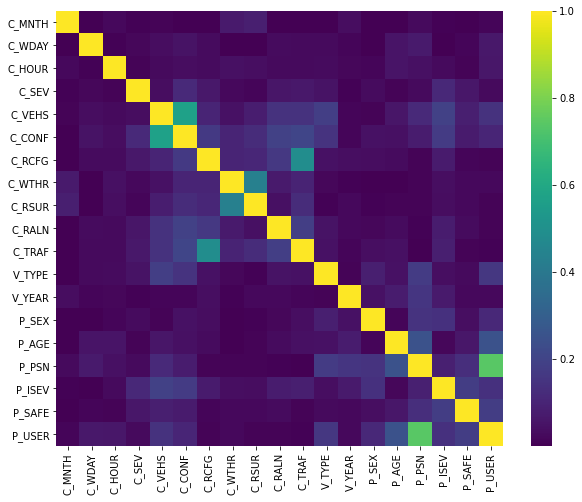

In [16]:
plt.figure(figsize = (10, 8))
sns.heatmap(corr.abs(), cmap = 'viridis')
plt.show()

In [17]:
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) 
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr.correlation > 0.1]

,level_0,level_1,correlation
357,P_USER,P_PSN,0.739235
99,C_CONF,C_VEHS,0.568066
196,C_TRAF,C_RCFG,0.486168
159,C_RSUR,C_WTHR,0.430428
356,P_USER,P_AGE,0.252110
299,P_PSN,P_AGE,0.250801
195,C_TRAF,C_CONF,0.203634
308,P_ISEV,C_VEHS,0.192265
176,C_RALN,C_CONF,0.191684
213,V_TYPE,C_VEHS,0.183342


# Sampling variable C_SEV

In [18]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

Como ya vimos en el analisis EDA, es facilmente apreciable la gran diferencia del computo total de valores 0 y 1 en la variable objetivo. Este caso puede afectar a predecir peor los ceros y unos, por esta razon realizaremos un aumento del valor menor para compensar esa diferencia y reducir la brecha entre ambos valores.

Primeramente aislaremos la variable traget del resto del data set

In [19]:
X = df_car_t.drop('C_SEV', axis=1)
Y = df_car_t.C_SEV

Realizamos un split de los vectores antes creados donde train sera la muestra completa menos el porcentaje que asignamos a xtest para testear os resultados de xtrain. Realizamos el mismo proceso para la variable target.

In [20]:
xtrain, xtest, ytrain, ytest = train_test_split( X, Y, test_size=0.2, random_state=0)

A continuación realizamos un paso muy importante comentado al principio de este apartado, el aumento de la muestra para el valor minoritario dentro de C_SEV. Para ello importamos SMOTE cuya funcion principal es aumentar los valores uno(al menos una muerte) de manera sintetica, es decir, no son valores reales para que el resultado final no se vea afectado por este desajuste.

In [21]:
sm = SMOTE(random_state = 12345, n_jobs=-1, sampling_strategy=0.3)
X_train_sampled, y_train_sampled =sm.fit_resample(xtrain, ytrain)
X_train = pd.DataFrame(X_train_sampled, columns = xtrain.columns)

Comprobamos que el size de los respectivos Xtrain e ytrain siguen siendo igual, ya que esto podría darnos problemas a la hora de aplicar los modelos

In [22]:
print(len(X_train))
print(len(xtest))
print(len(y_train_sampled))
print(len(ytest))

5373681
1051112
5373681


Finalmente, tambien realizaremos una normalización de las variables cuya funcionalidad principal es calcular la distancia o posicion del valor respecto de su minimo comprimido en un rago delimitado por su propio máximo y minimo. 

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
model_scaled = scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(xtest), columns=xtest.columns, index=xtest.index)

In [24]:
print(len(X_train_scaled))
print(len(X_test_scaled))
print(len(y_train_sampled))
print(len(ytest))

5373681
1051112
5373681
1051112


# Seleccion de variables PCA 

Una vez ya arregladas las variables y sus respectivos valores, antes de pasar al modelo vamos a realizar un modelo previo el cual se basa en obtener ciertos componentes los cuales son inferiores al numero de variables que tenemos para explicar la variable objetivo. Por tanto, condensa la información aportada de todas las variables en unos pocos componentes.

Estos componentes estan ordenados de mayor a menor y constituyen cada uno una dimension compuesta por las asociaciones entre la variable objetivo y las diferentes variables. Por tanto, el primer componente tendra el mayor peso.

Cuanto mayor sea el valor de la variable, más importante será la variable correspondiente en el cálculo del componente.

In [27]:
pca = PCA() #primero lo hago sin fijar el número de componentes para poder ver cual es la varianza total de cada una

pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

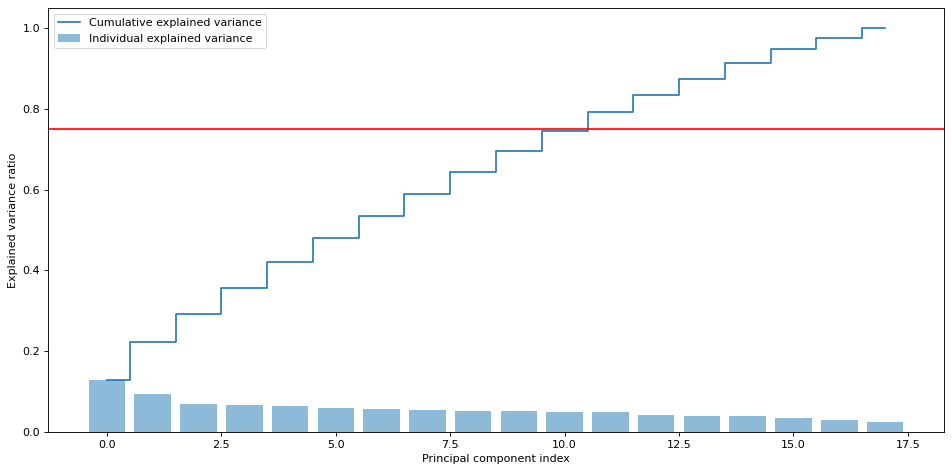

In [28]:
exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

threshold = 0.75
plt.figure(figsize=(12, 6), dpi=80)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.axhline(y=threshold, color='r', linestyle='-')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Fijandonos en la grafica superior, vemos que con el treshold establecido el numero correcto de componentes para explicar el comportamiento de la variable es 10.

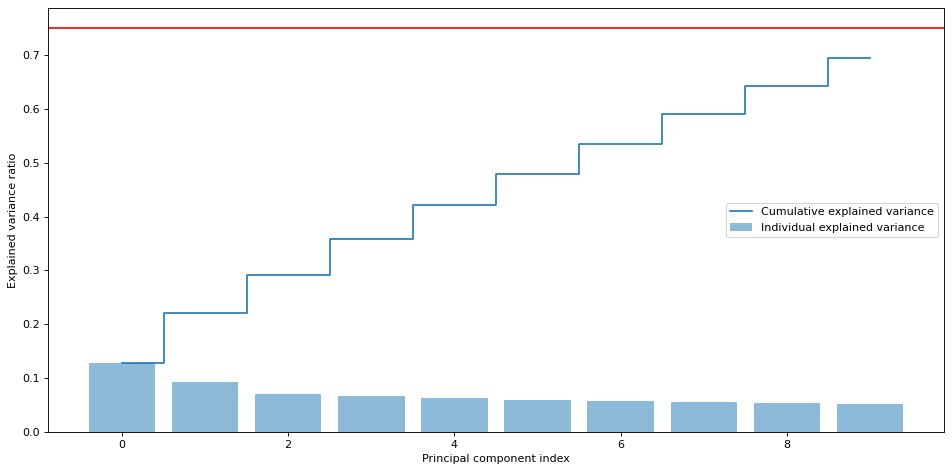

In [29]:
pca = PCA(n_components=10)

pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

threshold = 0.75
plt.figure(figsize=(12, 6), dpi=80)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.axhline(y=threshold, color='r', linestyle='-')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Finalmente, segun los componentes obtenidos los agruparemos en un  nuevo dataframe el cual será a partir de aquí nuestras nuevas xtrain e xtest

In [30]:
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)
X_train_pca.columns = ['PCA_'+str(i) for i in X_train_pca.columns]
X_test_pca.columns = ['PCA_'+str(i) for i in X_test_pca.columns]
X_train_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9
0,-0.064959,-0.927713,1.021221,-0.614613,-0.172439,0.945522,0.812201,-0.221614,-0.777036,0.451877
1,0.606134,-0.606572,0.026933,1.247239,-0.761469,1.298610,1.385577,-0.880288,-0.025394,-0.560066
2,0.388529,2.892399,0.785844,0.010679,-0.638172,0.773639,0.538911,-0.841573,0.491847,2.470473
3,1.440274,-1.580730,-0.721348,-0.899456,-0.767012,0.750992,-0.443611,-0.398142,-0.512382,0.835128
4,-1.617591,1.156087,0.402289,0.054418,1.243247,-0.965560,0.042381,-0.830873,-0.685114,-1.193587


In [31]:
X_train_pca.shape

(5373681, 10)

# MODELO RANDOM FOREST

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

### Obtencion de parametros y entrenamiento

Antes de entrenar el modelo, vamos a obtener los mejores hyperparametros con un CV.  Max_depth definimos la profundidad de nuestro arbol, es decir, entre 2 y 6 decisiones binarias. Por otro lado con el criterio busvamos una funcion que  mida la calidad de la division. 

In [35]:
param_test = {
    'max_depth' : [2,6],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini','entropy'] 
 }

gsearch_RandomForest = GridSearchCV(estimator = RandomForestClassifier(80), 
                               param_grid = param_test, scoring='roc_auc',n_jobs=-1, refit = True)

In [37]:
gsearch_RandomForest.fit(X_train_pca, y_train_sampled)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=80), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 6],
                         'max_features': ['auto', 'sqrt', 'log2']},
             scoring='roc_auc')

Aqui obersvamos cuales son los mejores parametros que se ajustan a nuestros datos según nuestros criterios establecidos.

In [38]:
gsearch_RandomForest.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=6, max_features='sqrt',
                       n_estimators=80)

In [39]:
gsearch_RandomForest.best_params_

{'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt'}

A continuación, entrenamos el modelo con los hyperparametros obtenidos

In [42]:
Best_RF = gsearch_RandomForest.best_estimator_
Best_RF.fit(X_train_pca, y_train_sampled)

RandomForestClassifier(criterion='entropy', max_depth=6, max_features='sqrt',
                       n_estimators=80)

In [43]:
# Probabilidad predictiva de X_test_pca. Observamos un rango muy amplio
LeadScore = Best_RF.predict_proba(X_test_pca)
print(LeadScore)

[[0.89592413 0.10407587]
 [0.90185417 0.09814583]
 [0.6157993  0.3842007 ]
 ...
 [0.92848421 0.07151579]
 [0.87189885 0.12810115]
 [0.92342341 0.07657659]]


In [44]:
# Prediccion de los valores
pred = Best_RF.predict(X_test_pca)

# 0 si es incorrecto, 1 si lo es
print(pred)

[0 0 0 ... 0 0 0]


In [45]:
# Obtenemos el porcentaje de casos que el modelo ha acertado.
accuracy_score(ytest, pred)

0.966883643227363

### Matriz de confianza

In [79]:
from sklearn.metrics import confusion_matrix

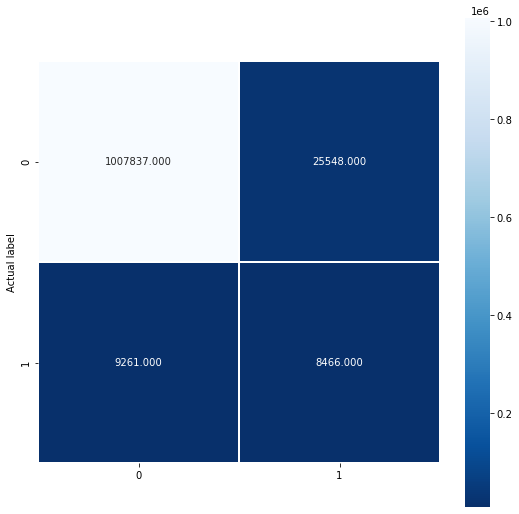

In [80]:
# Representacion visual a traves de la matriz de confianza de nuestras predicciones en base a los valores reales
cm_rf = confusion_matrix(ytest, pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm_rf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');

In [81]:
from sklearn.metrics import plot_confusion_matrix

Confusion matrix, without normalization
[[1007837   25548]
 [   9261    8466]]
Normalized confusion matrix
[[0.97527737 0.02472263]
 [0.52242342 0.47757658]]


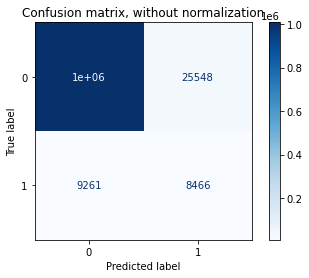

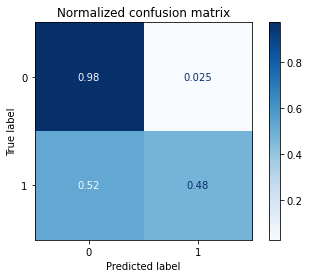

In [84]:
# Mostramos tanto la maxtriz de confusion como la normalizada.
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(gsearch_RandomForest, X_test_pca, ytest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

### AUC-ROC CURVE

Esta grafica es una buena métrica para evaluar el rendimiento de nuestro modelo de clasificación, por tanto no esta mostrando que tan bueno es nuestro modelo para predecir entre dos cosas.
Observamos como tenemos en el eje x tenemos el false positive rate que es el ratio de fallar un positivo entre el total, y lo contrario con el tru positive rate.

Por tanto junto con la matriz de confusion y observando la curva roc, tenemos que para la estimacion del valor cero tenemos un true positive rate cercano al 60%, conocido tambien como sensibilidad o recall, junto a un false positive rate cercano a cero.

Por otro lado, contamos con el area de bajo de la curva roc llamada AUC que contiene un 85%, lo que nos quiere decir es el porcentaje de que el modelo pueda distinguir entre ceros y unos.

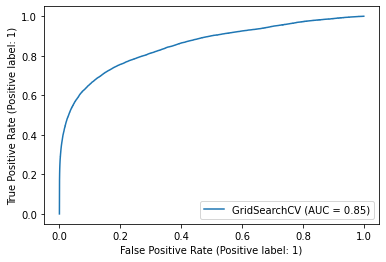

In [83]:
metrics.plot_roc_curve(gsearch_RandomForest, X_test_pca, ytest)
plt.show()

### Cumulative Gain Curve

En la baseline de la curva de ganancias acumuladas tiene la misma tendencia que la curva class 0, lo cual nos indica que a medidas que aumentamos el porcentaje de la muestra hasta llegar al 100%, vamos obteniendo el mismo numero de valores verdaderos de cero. Por lo contrario, la linea de class 1 sgue una tendencia diferente, y es que entre el 0% y 20% de la muestra obtenemos casi el 80% de sus valores verdaderos. Seguidamente, la curva empieza a tebner una tendencia mas plana hasta llegar a obtener todos los valores vervaderos con el 100% de la muestra.

In [86]:
predicted_probas = gsearch_RandomForest.predict_proba(X_test_pca)

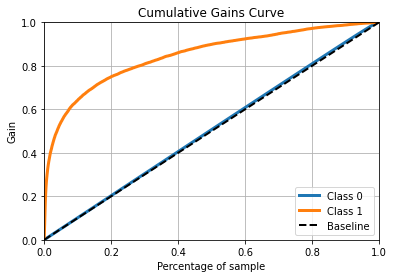

In [87]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(ytest, predicted_probas)
plt.show()

### Lift Curve

En la siguiente curva, tiene una forma contraria a la cumulative gain curve. Esta gráfica nos muestra como cual es la efectividad del modelo resecto al aumento de la muestra. Observamos que la linea class 0 es perfecta ya que esta sobre la baseline por tanto tiene una prediccion del 100% (problema de overfiting). Por otro lado, class 1 cuando la muestra es pequeña no obtiene un gran resultado pero a medida que aumenta la muestra tiende al mismo valor que la class 0.

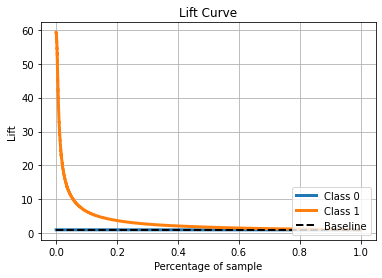

In [88]:
skplt.metrics.plot_lift_curve(ytest, predicted_probas)
plt.show()

# Histograma de las probabilidades predecidas

Text(0, 0.5, 'Frequency')

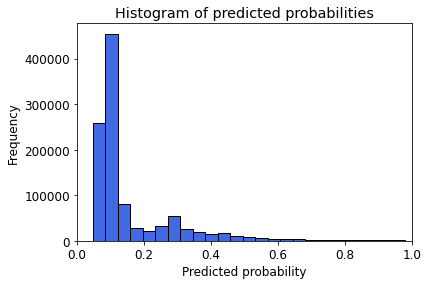

In [89]:
y_pred_prob = predicted_probas[:, 1]

plt.rcParams['font.size'] = 12
plt.hist(y_pred_prob, bins=25,facecolor='royalblue', edgecolor = 'black')
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability')
plt.ylabel('Frequency')

In [94]:
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98   1033385
           1       0.25      0.48      0.33     17727

    accuracy                           0.97   1051112
   macro avg       0.62      0.73      0.66   1051112
weighted avg       0.98      0.97      0.97   1051112



# Guardamos el modelo

In [98]:
import pickle

In [99]:
model = gsearch_RandomForest
filename = 'RandomForest.sav'
pickle.dump(model, open(filename, 'wb'))

In [100]:
filename3 = 'RandomForest.sav'
RF = pickle.load(open(filename3, 'rb'))
pred = RF.predict(X_test_pca)
accuracy_score(ytest, pred) 

0.966883643227363

In [ ]:
# Guardamos las xtest e ytest tratados en el modelo final para poder realizar la interpretabilidad en el siguientr script
X_train_pca.to_parquet("X_train_pca.parquet")
X_test_pca.to_parquet("X_test_pca.parquet")
pd.DataFrame(y_train_sampled).to_parquet('y_train_sampled.parquet')
pd.DataFrame(ytest).to_parquet('ytest.parquet')